# Objective and Motivation

## Objective

## Overview of Wind Turbine Anatomy

## Wind Turbine Aerodynamics

# Code

### Pip Install, Init, and Start Pyspark

In [1]:
# from pyspark.sql import SparkSession
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# from pyspark.sql import functions as F
# from pyspark.sql import types as T
# from pyspark.sql.functions import broadcast
# from pyspark.sql.functions import col
# from pyspark.sql.functions import *
import seaborn as sns

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, f1_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
import mlflow



# Enable autologging for scikit-learn
mlflow.sklearn.autolog()

In [4]:
# from ydata_profiling import ProfileReport

In [5]:
# spark = SparkSession.builder.master("local[*]").getOrCreate()
# sc = spark.sparkContext

In [6]:
# Get the number of cores
# num_cores = sc.defaultParallelism

# Get the number of executors
# num_executors = sc.getConf().get("spark.executor.instances")

# print(num_cores)
# print(num_executors)

In [7]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

### Import Data 

In [8]:
print(os.getcwd())

/home/mathewlee/Developer/wind-energy-forecasting/notebooks


In [9]:
df = pd.read_csv("../src/main/resources/data/Turbine_Data.csv")

In [10]:
# df = (spark.read
#       .option("header", "true")
#       .option("inferSchema", "true")
#       .csv("../data/Turbine_Data.csv"))

In [11]:
# df.printSchema()

### Transform Data

In [12]:
# df_renamed = df.withColumnRenamed("_c0", "datetime_stamp")


In [13]:
df_renamed = df.rename({"Unnamed: 0": "datetime_stamp"}, axis=1)

In [14]:
df_renamed.columns

Index(['datetime_stamp', 'ActivePower', 'AmbientTemperatue',
       'BearingShaftTemperature', 'Blade1PitchAngle', 'Blade2PitchAngle',
       'Blade3PitchAngle', 'ControlBoxTemperature',
       'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
       'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
       'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG', 'WindDirection',
       'WindSpeed'],
      dtype='object')

In [15]:
df_renamed['datetime_stamp'] = pd.to_datetime(df_renamed['datetime_stamp'])

In [16]:
df_indexed_sorted = df_renamed.set_index("datetime_stamp").sort_index()

In [17]:
df_indexed_sorted.dtypes

ActivePower                     float64
AmbientTemperatue               float64
BearingShaftTemperature         float64
Blade1PitchAngle                float64
Blade2PitchAngle                float64
Blade3PitchAngle                float64
ControlBoxTemperature           float64
GearboxBearingTemperature       float64
GearboxOilTemperature           float64
GeneratorRPM                    float64
GeneratorWinding1Temperature    float64
GeneratorWinding2Temperature    float64
HubTemperature                  float64
MainBoxTemperature              float64
NacellePosition                 float64
ReactivePower                   float64
RotorRPM                        float64
TurbineStatus                   float64
WTG                              object
WindDirection                   float64
WindSpeed                       float64
dtype: object

In [18]:
pdf = df_indexed_sorted.copy()

In [19]:
# df_casted = df_renamed.withColumn("datetime_stamp", col("datetime_stamp").cast("timestamp")).drop(col("_c0"))
# df_casted.printSchema()

In [20]:
# df_filtered = df_casted.where(
#     to_date(col("datetime_stamp")) =="2018-01-01"
#     )

In [21]:
# pdf = df_casted.toPandas()

In [22]:
# profile = ProfileReport(pdf, title="YData Profiling Report")
# profile.to_file('profiling_report.html');

### Drop Empty or Single Value Cols

In [23]:
pdf_drop_bad_cols = pdf.drop(columns=['ControlBoxTemperature', 'TurbineStatus', 'WTG'], axis=1)

In [24]:
type(pdf_drop_bad_cols)

pandas.core.frame.DataFrame

### Drop Highly Correlated Columns

In [25]:
corr_matrix = pdf_drop_bad_cols.corr()
corr_matrix


,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,WindDirection,WindSpeed
ActivePower,1.000000,-0.065637,0.655400,-0.368997,-0.367978,-0.367978,0.818850,0.821921,0.849604,0.931390,0.932521,0.347363,0.101627,0.028108,0.719092,0.849069,0.028108,0.940390
AmbientTemperatue,-0.065637,1.000000,0.246505,0.085461,0.090904,0.090904,0.017216,0.162511,-0.130123,0.077859,0.078736,0.589729,0.836539,-0.037498,-0.020313,-0.129290,-0.037498,-0.095308
BearingShaftTemperature,0.655400,0.246505,1.000000,-0.475557,-0.466856,-0.466856,0.883344,0.772887,0.640947,0.765115,0.763926,0.809116,0.542104,0.183929,0.594546,0.640584,0.183929,0.596201
Blade1PitchAngle,-0.368997,0.085461,-0.475557,1.000000,0.997774,0.997774,-0.599178,-0.557949,-0.757056,-0.376102,-0.372369,-0.198583,0.194911,-0.058300,-0.381478,-0.757147,-0.058300,-0.403092
Blade2PitchAngle,-0.367978,0.090904,-0.466856,0.997774,1.000000,1.000000,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.057624,-0.402786
Blade3PitchAngle,-0.367978,0.090904,-0.466856,0.997774,1.000000,1.000000,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.057624,-0.402786
GearboxBearingTemperature,0.818850,0.017216,0.883344,-0.599178,-0.592103,-0.592103,1.000000,0.906020,0.850209,0.853024,0.851923,0.596065,0.307694,0.214486,0.751875,0.850795,0.214486,0.800433
GearboxOilTemperature,0.821921,0.162511,0.772887,-0.557949,-0.549792,-0.549792,0.906020,1.000000,0.806972,0.899693,0.898335,0.506648,0.190350,0.277619,0.770088,0.807776,0.277619,0.793140
GeneratorRPM,0.849604,-0.130123,0.640947,-0.757056,-0.754325,-0.754325,0.850209,0.806972,1.000000,0.796434,0.795223,0.303804,-0.052185,0.176964,0.768065,0.999723,0.176964,0.854787
GeneratorWinding1Temperature,0.931390,0.077859,0.765115,-0.376102,-0.371057,-0.371057,0.853024,0.899693,0.796434,1.000000,0.999959,0.481905,0.215955,0.298452,0.838461,0.797077,0.298452,0.894777


In [26]:
corr_matrix.abs().unstack()["NacellePosition"]

ActivePower                     0.028108
AmbientTemperatue               0.037498
BearingShaftTemperature         0.183929
Blade1PitchAngle                0.058300
Blade2PitchAngle                0.057624
Blade3PitchAngle                0.057624
GearboxBearingTemperature       0.214486
GearboxOilTemperature           0.277619
GeneratorRPM                    0.176964
GeneratorWinding1Temperature    0.298452
GeneratorWinding2Temperature    0.298708
HubTemperature                  0.128150
MainBoxTemperature              0.005701
NacellePosition                 1.000000
ReactivePower                   0.294038
RotorRPM                        0.176511
WindDirection                   1.000000
WindSpeed                       0.034355
dtype: float64

In [27]:
corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().head(20)

WindSpeed                     WindSpeed                       1.000000
GeneratorWinding2Temperature  GeneratorWinding1Temperature    0.999959
GeneratorRPM                  RotorRPM                        0.999723
Blade3PitchAngle              Blade1PitchAngle                0.997774
WindSpeed                     ActivePower                     0.940390
ActivePower                   GeneratorWinding2Temperature    0.932521
                              GeneratorWinding1Temperature    0.931390
GearboxBearingTemperature     GearboxOilTemperature           0.906020
GearboxOilTemperature         GeneratorWinding1Temperature    0.899693
                              GeneratorWinding2Temperature    0.898335
WindSpeed                     GeneratorWinding2Temperature    0.894834
                              GeneratorWinding1Temperature    0.894777
GearboxBearingTemperature     BearingShaftTemperature         0.883344
RotorRPM                      WindSpeed                       0.855584
Genera

In [28]:
### Drop highly correlated features
### pdf[["WindSpeed","ActivePower"]]
### pdf[["RotorRPM", "GeneratorRPM"]]
### pdf[["AmbientTemperatue", "MainBoxTemperature"]]
### pdf[["Blade1PitchAngle","Blade2PitchAngle", "Blade3PitchAngle"]]
### pdf[["NacellePosition","WindDirection"]]


df_drop_corr_cols = pdf.drop(["NacellePosition","RotorRPM", "AmbientTemperatue", "Blade2PitchAngle", "Blade3PitchAngle"], axis=1)


In [29]:
df_drop_corr_cols

,ActivePower,BearingShaftTemperature,Blade1PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,TurbineStatus,WTG,WindDirection,WindSpeed
datetime_stamp,,,,,,,,,,,,,,,,
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 23:10:00+00:00,70.044465,45.711129,1.515669,0.0,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,13.775785,2.0,G01,178.0,3.533445
2020-03-30 23:20:00+00:00,40.833474,45.598573,1.702809,0.0,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,8.088928,2.0,G01,178.0,3.261231
2020-03-30 23:30:00+00:00,20.777790,45.462045,1.706214,0.0,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,4.355978,2.0,G01,178.0,3.331839


### Drop Null Rows

In [30]:
df_drop_nulls = df_drop_corr_cols.dropna(subset=["ActivePower"]).sort_index()
# df_drop_nulls = df_drop_corr_cols.sort_index()

In [31]:
### Percent non-null
df_drop_nulls.shape[0]/pdf.shape[0]

0.8014447151170659

In [32]:
df_drop_nulls.shape

(94750, 16)

### Fit and Forecast (SARIMA)

In [33]:
class time_seriesForecastSARIMA():
    def __init__(self, df: pd.DataFrame, seasonal_periods: int, train_test_date_split_mid_pt: str, y_variable: str = "ActivePower", grain: str = "W-MON",
                 p: int = 0, d: int = 0, q: int = 0, P: int = 0, D: int = 0, Q: int = 0):
        self.seasonal_periods = seasonal_periods
        self.p = p
        self.d = d
        self.q = q
        self.P = P
        self.D = D
        self.Q = Q
        
        self.X_train, self.X_test = self._train_test_split_by_date(df, train_test_date_split_mid_pt)
        self.X_train_resampled, self.X_test_resampled = self._resample_mean(self.X_train, self.X_test, y_variable=y_variable, grain=grain)

    def _train_test_split_by_date(self, df: pd.DataFrame, train_test_date_split_mid_pt: str) -> tuple[pd.DataFrame, pd.DataFrame]:
        X_train = df.iloc[df.index <= train_test_date_split_mid_pt]
        X_test = df.iloc[df.index > train_test_date_split_mid_pt]
        return X_train, X_test
    
    def _resample_mean(self, X_train: pd.DataFrame, X_test: pd.DataFrame, y_variable: str, grain: str) -> tuple[pd.Series, pd.Series]:
        return X_train[y_variable].resample(grain).mean(), X_test[y_variable].resample(grain).mean()

    # def _apply_differencing(self, time_series: pd.Series):
        # return diff(time_series, k_seasonal_diff=1, seasonal_periods=self.seasonal_periods)

    def plot_time_series(self, train_time_series: pd.Series, test_time_series: pd.Series) -> None:
        plt.figure(figsize=(10, 6))
        plt.plot(train_time_series)
        plt.plot(test_time_series)
        plt.title("Active Power Generated")
        plt.xlabel("Date")
        plt.ylabel("ActivePower")
        plt.show()
        return None

    def check_stationarity(self, time_series: pd.Series) -> None:
        result = adfuller(time_series, autolag='AIC')
        p_value = result[1]
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {p_value}')
        print('Stationary' if p_value < 0.05 else 'Non-Stationary')
        return None

    def generate_acf_pacf(self, time_series: pd.Series) -> None:
        plot_acf(time_series)
        plot_pacf(time_series)
        plt.show()

    def fit_and_forecast(self, time_series: pd.Series, forecast_n_steps: int) -> None:
        model = SARIMAX(time_series, order=(self.p, self.d, self.q), seasonal_order=(self.P, self.D, self.Q, self.seasonal_periods))
        results = model.fit()
        forecast = results.get_forecast(steps=forecast_n_steps)
        forecast_values = forecast.predicted_mean
        forecast_ci = forecast.conf_int()
        print(time_series.index[-1])
        print(pd.DateOffset(months=1))
        print(forecast_ci)

        # return results.forecast(steps=forecast_n_steps), forecast_values, lower_ci_series, upper_ci_series, results.resid
        return results.forecast(steps=forecast_n_steps), forecast_values, forecast_ci, results.resid

    def plot_forecast(self, time_series: pd.Series, forecast):
        plt.figure(figsize=(10, 6))
        plt.plot(time_series, label='Observed')
        plt.plot(forecast, label='Forecast', color='red')
        # plt.fill_between(
        #     range(0,3),
        #     forecast_ci.iloc[:, 0],
        #     forecast_ci.iloc[:, 1],
        #     color='orange',
        #     alpha=0.2,
        #     label="Confidence Interval"
        # )
        plt.title("Active Power Forecast")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.show()
        
    def plot_training_testing_forecast_CI(self, 
                                          X_train_time_series: pd.Series, 
                                            X_test_time_series: pd.Series, 
                                            forecast: pd.Series,
                                            forecast_ci: pd.Series,
                                            # lower_series: pd.Series, upper_series: pd.Series
                                            ):
        plt.figure(figsize=(10, 6))
        plt.plot(X_train_time_series, label='Training')
        plt.plot(X_test_time_series, label='Actuals', color='orange')
        plt.plot(forecast, label='Forecast', color='red')
        plt.fill_between(forecast_ci.index,
                        forecast_ci.iloc[:,0],
                        forecast_ci.iloc[:,1],
                        color='k', alpha=.15)

        plt.title("Active Power Forecast")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.show()

    def evaluate_forecast(self, X_test: pd.Series, forecast) -> None:
        # print(X_test[1:].sort_index())
        # print(forecast.sort_index())

        mae = mean_absolute_error(X_test[1:], forecast)
        mape = mean_absolute_percentage_error(X_test[1:], forecast)
        mse = mean_squared_error(X_test[1:], forecast)
        rmse = root_mean_squared_error(X_test[1:], forecast)

        print(f'MAE: {mae}')
        print(f'MAE: {mape}')
        print(f'MSE: {mse}')
        print(f'RMSE: {rmse}')

        return mae, mape, mse, rmse
        


In [34]:
# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}


Plotting X_train without differencing but with resampling


/home/mathewlee/Developer/wind-energy-forecasting/.venv/lib64/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/mathewlee/Developer/wind-energy-forecasting/.venv/lib64/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2019-03-04 00:00:00+00:00
<DateOffset: months=1>
                           lower ActivePower  upper ActivePower
2019-03-11 00:00:00+00:00         -16.090086         688.186976
2019-03-18 00:00:00+00:00        -493.037239         441.254813
2019-03-25 00:00:00+00:00        -515.857505         608.494792
2019-04-01 00:00:00+00:00        -727.990721         557.923407
2019-04-08 00:00:00+00:00        -866.788946         562.623738
2019-04-15 00:00:00+00:00        -859.150335         700.604608
2019-04-22 00:00:00+00:00       -1006.085161         673.930993
2019-04-29 00:00:00+00:00        -947.584823         844.640767
2019-05-06 00:00:00+00:00        -902.265452         995.546688
2019-05-13 00:00:00+00:00       -1084.103411         913.722724
2019-05-20 00:00:00+00:00       -1125.478248         967.588310
2019-05-27 00:00:00+00:00       -1237.550704         946.607249
2019-06-03 00:00:00+00:00       -1077.572682        1194.026823
2019-06-10 00:00:00+00:00        -537.199257        181

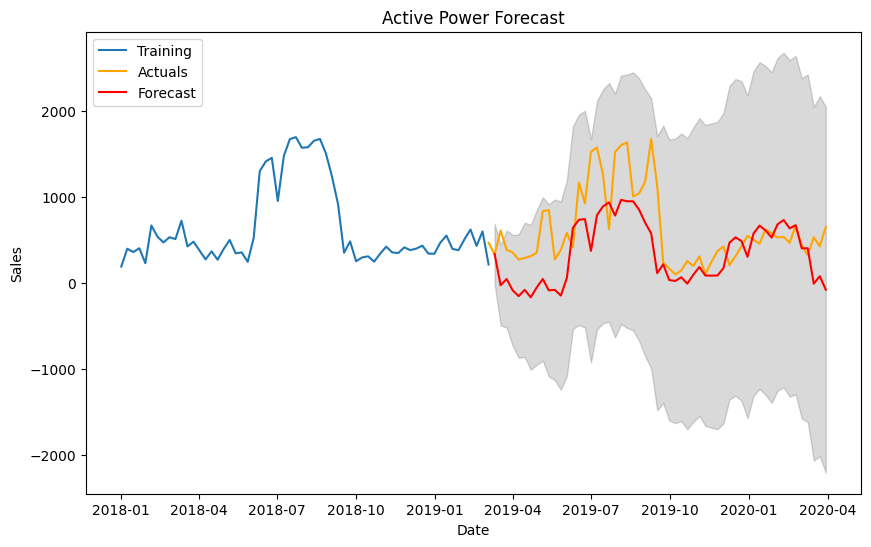

MAE: 347.0870946910216
MAE: 0.6216651457914352
MSE: 205173.5919221818
RMSE: 452.96091655040374


In [38]:
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run(run_name='SARIMAX'):
    weekly_forecast = time_seriesForecastSARIMA(df=df_drop_nulls, seasonal_periods=26, 
                                            train_test_date_split_mid_pt="2019-03-01", y_variable="ActivePower", grain="W-MON", 
                                           p=1, d=1, q=0, P=1, D=1, Q=1)


    ### Plot X_train with differencing but without resampling
    print("Plotting X_train without differencing but with resampling")
    # weekly_forecast.plot_time_series(weekly_forecast.X_train_resampled, weekly_forecast.X_test_resampled)
    # weekly_forecast.check_stationarity(weekly_forecast.X_train_resampled)
    # weekly_forecast.generate_acf_pacf(weekly_forecast.X_train_resampled)


    ### Fit and ForecaSt, then plot
    forecast, forecast_values, forecast_ci, residuals = weekly_forecast.fit_and_forecast(weekly_forecast.X_train_resampled, 
                                                                                        forecast_n_steps=len(weekly_forecast.X_test_resampled)-1)

    # weekly_forecast.plot_forecast(weekly_forecast.X_train_resampled, forecast_values)
    weekly_forecast.plot_training_testing_forecast_CI(X_train_time_series= weekly_forecast.X_train_resampled, 
                                                        X_test_time_series =  weekly_forecast.X_test_resampled, 
                                                        forecast = forecast,
                                                        forecast_ci = forecast_ci,
                                                    )

    # weekly_forecast.generate_acf_pacf(residuals)


    # Log Input
    # mlflow.log_input(pd.DataFrame(weekly_forecast.X_train_resampled), context="Training Data Resampled")
    # mlflow.log_input(pd.DataFrame(weekly_forecast.X_test_resampled), context="Test Data Resampled")
    
    # Log the hyperparameters
    # mlflow.log_params(params)

    # Log the model
    # model_info = mlflow.sklearn.log_model(sk_model=lr, name="iris_model")

    # Predict on the test set, compute and log the loss metric
    mae, mape, mse, rmse = weekly_forecast.evaluate_forecast(weekly_forecast.X_test_resampled, forecast)
    mlflow.log_metric("accuracy", mae)
    mlflow.log_metric("accuracy", mape)
    mlflow.log_metric("accuracy", mse)
    mlflow.log_metric("accuracy", rmse)

    # Optional: Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

In [36]:


# with mlflow.start_run(run_name="PatchTST_Forecast"):
#     mlflow.log_input(tsai_ex_dataset, context='numpy timeseries')
#     mlflow.log_artifact("ts_splits.npz")
    
#     # fcst.fit_one_cycle(10, 1e-3)
#     # fcst.export("fcst.pkl")
#     preds, *_ = fcst.get_X_preds(X[splits[1]])  # Make predictions on validation set
#     rmse, mape_val = performance(df_ex['y'][-20:], np.array(preds[19][0]))

#     # Log params and metrics
#     mlflow.log_params({"epochs":10, "learning_rate": 1e-3, 'bs': 32, 'arch': "PatchTST", 
#                        'metrics': 'mae', 'fcst_history': 30, 'fcst_horizon': 20, 'test_size': 20})
    
#     mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
#     mlflow.sklearn.log_model(sk_model=fcst, name="PatchTST model",
#         serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE, input_example=df_ex.head())



## Sources

https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/

In [37]:
### Apply Differencecing
# print("Apply Differencing")
# X_train_resampled_differenced = pd.Series(self._apply_differencing(X_train_resampled))
# X_test_resampled_differenced = pd.Series(self._apply_differencing(X_test_resampled))

### Plot X_train with differencing and resampling
# print("Plotting X_train with Differencing and resampling")
# weekly_forecast._plot_time_series(X_train_resampled, X_test_resampled)
# weekly_forecast._check_stationarity(X_train_resampled)
